# **Analysis of Mergers Acquisitions with special focus on the Technology Sector**


This notebook is a working document implemented in Python encompassing data sanitization, exploratory analysis and model development using M&A data from three different data sources. This has been developed for credit in the Capstone project towards the completion of MSc in Financial Engineering from WorldQuant University.

A [GitHub Repository](https://github.com/d33ksh2/MScFE_7849_Capstone) has been created for our current project containing all the data, requirements file and this ipython notebook that has the code and analysis developed for the Capstone project.

## Library Imports

In [125]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

## Data Sources



Data sourcing related to Mergers and Acquisitions presents unique challenges due to the lack of publicly available open-source datasets. The primary objective of our project is to apply advanced Data Science and Financial Analysis techniques to M&A activities in the Technology sector and obtain valuable insights that can help various stakeholders in their decision making.

Since no single data source contains a "perfect" dataset that can fully support our objectives, we are utilizing three different datasets which provide unique insights and perspectives into M&A activities in the Technology sector.

However, the machine Learning models in our current work are however built on a sector-agnostic dataset containing M&A transactions across various sectors as filtering for data only from the Technology sector does not leave us with a sufficient dataset for model training and evaluation. We shall however continue our efforts to find a more suitable and sufficiently large dataset specific to the Technology sector and, if successful, update this document before the final submission.

Following are the three data sources used in our current work:
- M&A Transactions dataset from MARC (private) containing details of over 51 thousand successful transactions from 31st December 1992 to 31st December 2008. There are over 90 columns of information regarding these transactions. Though this dataset contains a treasure trove of information regarding successful M&A transactions, it doesn't have any details of failed transactions which is why it cannot be used for ML model building. Hence, we are only using it for exploratory analysis and insights into M&A Transactions.
- Tech Acqusitions dataset containing acquisitions made by top tech companies namely Microsoft, Google, IBM, Hp, Apple, Amazon, Facebook, Twitter, eBay, Adobe, Citrix, Redhat, Blackberry and Disney from 1988 to 2021. This dataset was uploaded by Shivam Bansal to the open-source data repository on Kaggle and can be accessed from [here](https://www.kaggle.com/datasets/shivamb/company-acquisitions-7-top-companies/data). As this dataset also only contains successful M&A Transactions, we don't use this one either for ML modelling.
- Crunchbase M&A dataset containing 17 interesting columns including rounds of funding, number of people in the company with PhDs, number of offices, etc. It contains over 32 thousand data points of both mergers and non-mergers and thus is suitable for model building to predict the success of an M&A transaction given the availability of data corresponding to the input columns. This dataset was uploaded by Artem Nesterenko to the crunchbase GitHub repository and is accessible from [here](https://github.com/Crystalnix/crunchbase-ml/tree/master/data).

Datasets and their data dictionaries detailing the information about the columns they contain can be found in our GitHub repository for this project [linked here](https://github.com/d33ksh2/MScFE_7849_Capstone/tree/main/Data).

---
### **Note:** The current version of the notebook only contains detailed analysis and modelling of the Crunchbase M&A Dataset.

Our main objective was to use ML to predict the occurance of M&A transactions. Hence we focussed on the analysis and model development using the Crunchbase dataset.

Exploratory analysis of the other two datasets was an after thought and included into our plan recently to stay true to our initial goal of focussing on the Technology sector. The data preprocessing requirements and the complexity of these two datasets delayed the progress of their analysis, however this shall be completed before the final submission.

---

## Data Import

In [100]:
url_crunchbase = "https://raw.githubusercontent.com/d33ksh2/MScFE_7849_Capstone/main/Data/CrunchbaseML_MA_Dataset.csv"
df_crunchbase = pd.read_csv(url_crunchbase)
display(df_crunchbase.head(3))

,company_id,category_code,country_code,state_code,average_funded,total_rounds,average_participants,products_number,offices,acquired_companies,mba_degree,phd_degree,ms_degree,other_degree,ipo,is_acquired,is_closed,age
0,c:1,web,USA,other,13250000.0,3,3.0,2.0,2.0,NaN,5.0,1.0,3.0,18.0,False,False,False,2998.0
1,c:1001,web,USA,California,5000000.0,1,3.0,1.0,1.0,NaN,1.0,1.0,5.0,11.0,False,True,False,679.0
2,c:10014,mobile,USA,California,NaN,1,1.0,1.0,1.0,1.0,NaN,1.0,2.0,6.0,False,True,False,943.0


In [101]:
url_kaggle = "https://raw.githubusercontent.com/d33ksh2/MScFE_7849_Capstone/main/Data/Kaggle_TechAcquisitions_2021.csv"
df_kaggle = pd.read_csv(url_kaggle)

url_marc = "https://raw.githubusercontent.com/d33ksh2/MScFE_7849_Capstone/main/Data/MARC_MA_Dataset.xlsx"
df_marc = pd.read_excel(url_marc)

## Exploratory Data Analysis


The data dictionary for the Crunchbase dataset can be found in our GitHub repository [linked here](https://github.com/d33ksh2/MScFE_7849_Capstone/blob/main/Data/DataDictionary_Crunchbase_Dataset.md).

In [102]:
print("The shape of the Crunchbase DataFrame is:", df_crunchbase.shape)
print("\nColumn info of the Crunchbase Dataframe is:")
print(df_crunchbase.info())

The shape of the Crunchbase DataFrame is: (31984, 18)

Column info of the Crunchbase Dataframe is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   company_id            31752 non-null  object 
 1   category_code         30507 non-null  object 
 2   country_code          31984 non-null  object 
 3   state_code            31984 non-null  object 
 4   average_funded        28104 non-null  float64
 5   total_rounds          31984 non-null  int64  
 6   average_participants  31984 non-null  float64
 7   products_number       4043 non-null   float64
 8   offices               29607 non-null  float64
 9   acquired_companies    1529 non-null   float64
 10  mba_degree            8095 non-null   float64
 11  phd_degree            2741 non-null   float64
 12  ms_degree             6056 non-null   float64
 13  other_degree          

In [103]:
# Convert boolean columns to int for plotting
df_crunchbase["is_acquired"] = df_crunchbase["is_acquired"].astype(int)
df_crunchbase["ipo"] = df_crunchbase["ipo"].astype(int)
df_crunchbase["is_closed"] = df_crunchbase["is_closed"].astype(int)

In [104]:
# Checking for data imbalance

print("Proportions of mergers and non-mergers in the dataset are:")
print(df_crunchbase.is_acquired.value_counts(normalize=True)*100)

Proportions of mergers and non-mergers in the dataset are:
is_acquired
0    91.770885
1     8.229115
Name: proportion, dtype: float64


In [105]:
# Creating a DataFrame containing count and percent of null-values
df_crunchbase_stats = pd.DataFrame({
    'Missing Percent (%)': round(100 * df_crunchbase.isnull().mean(), 2),
    'Missing Count (#)': df_crunchbase.isnull().sum()
})
# Sort the DataFrame by the Missing Percentage in descending order
df_crunchbase_stats = df_crunchbase_stats.sort_values(by='Missing Count (#)', ascending=False)
display(df_crunchbase_stats)

,Missing Percent (%),Missing Count (#)
acquired_companies,95.22,30455
phd_degree,91.43,29243
products_number,87.36,27941
ms_degree,81.07,25928
mba_degree,74.69,23889
other_degree,52.09,16661
age,23.38,7479
average_funded,12.13,3880
offices,7.43,2377
category_code,4.62,1477


### Univariate Analysis

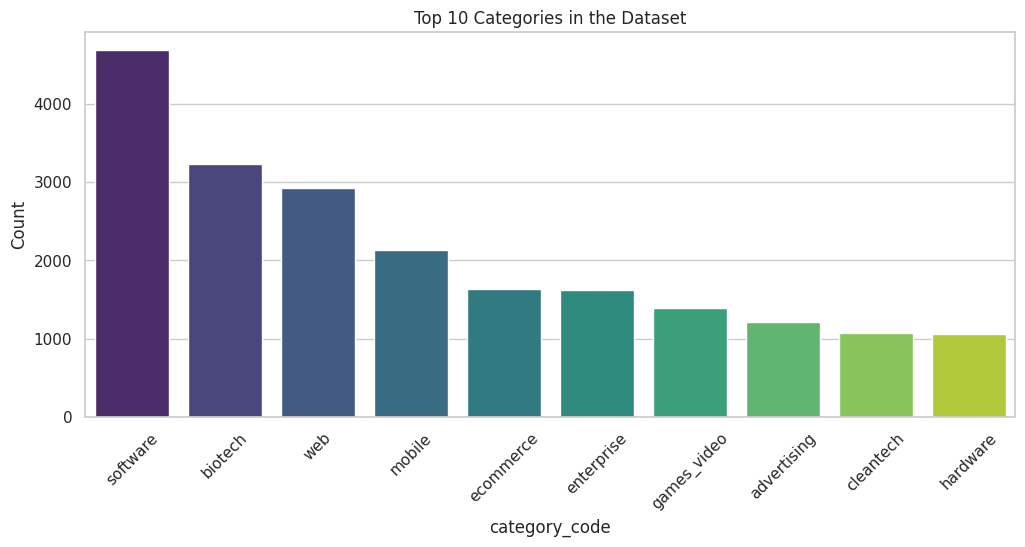

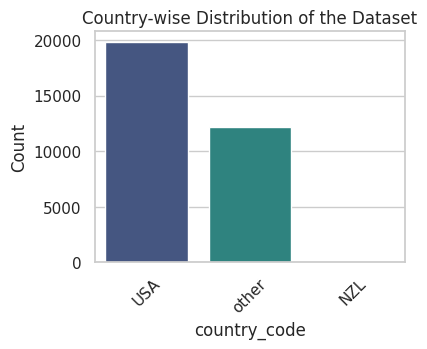

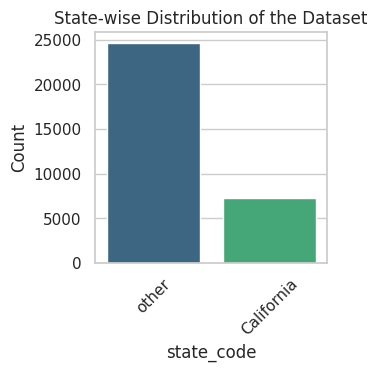

In [106]:
# Distribution of Categorical Variables
plt.figure(figsize=(12, 5))
top_categories = df_crunchbase["category_code"].value_counts().nlargest(10)  # Top 10
sns.barplot(x=top_categories.index, y=top_categories.values, hue = top_categories.index, palette="viridis")
plt.xticks(rotation=45)
plt.title(f"Top 10 Categories in the Dataset")
plt.xlabel("category_code")
plt.ylabel("Count")
plt.show()

print("\n")
plt.figure(figsize=(4, 3))
top_categories = df_crunchbase["country_code"].value_counts().nlargest(10)  # Top 10
sns.barplot(x=top_categories.index, y=top_categories.values, hue = top_categories.index, palette="viridis")
plt.xticks(rotation=45)
plt.title(f"Country-wise Distribution of the Dataset")
plt.xlabel("country_code")
plt.ylabel("Count")
plt.show()

print("\n")
plt.figure(figsize=(3, 3))
top_categories = df_crunchbase["state_code"].value_counts().nlargest(10)  # Top 10
sns.barplot(x=top_categories.index, y=top_categories.values, hue = top_categories.index, palette="viridis")
plt.xticks(rotation=45)
plt.title(f"State-wise Distribution of the Dataset")
plt.xlabel("state_code")
plt.ylabel("Count")
plt.show()

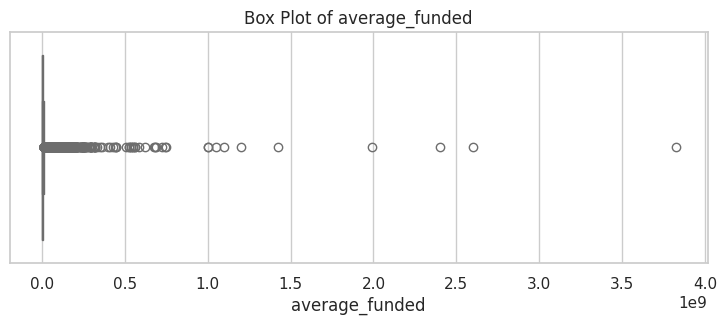

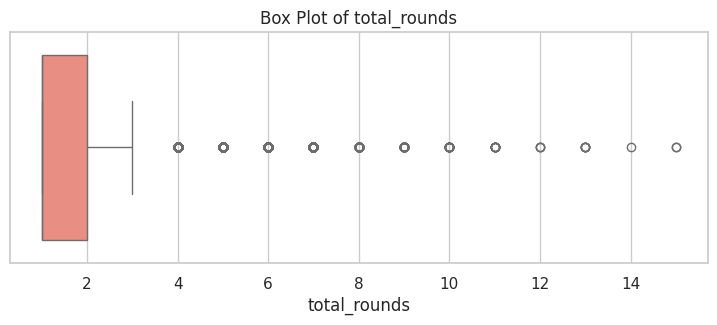

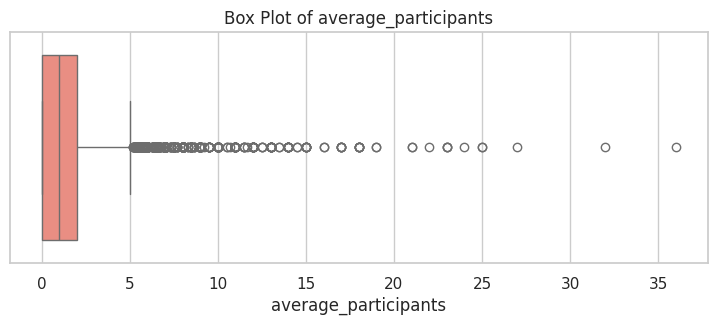

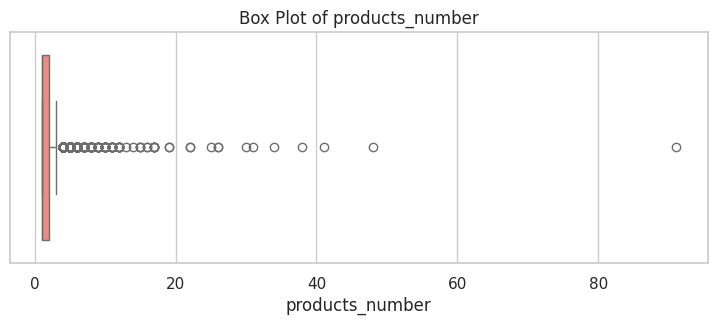

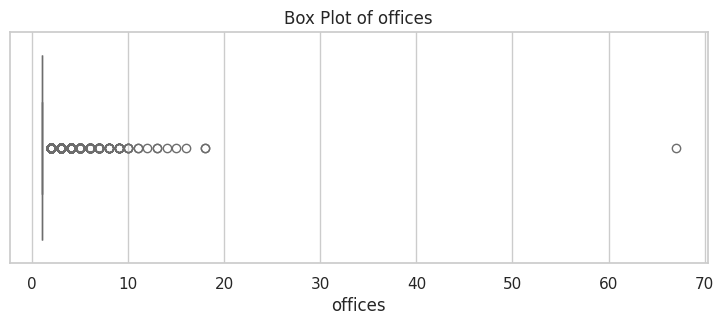

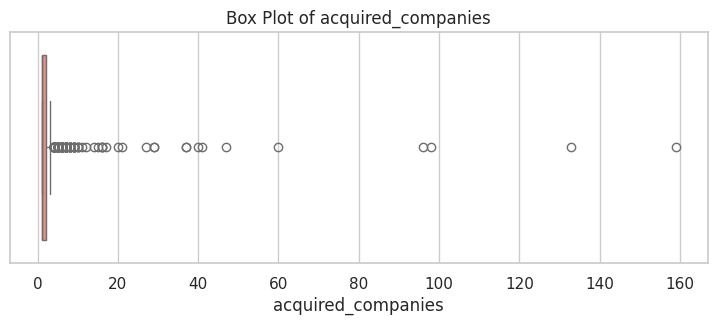

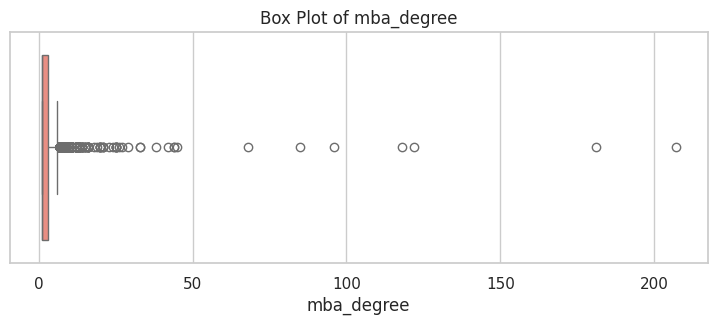

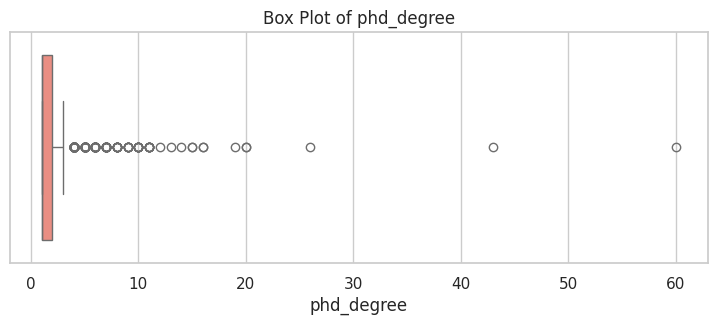

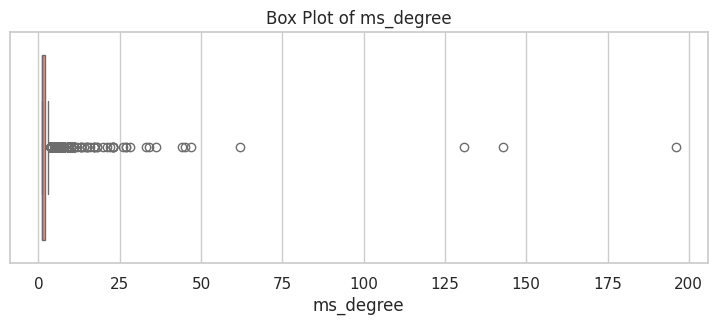

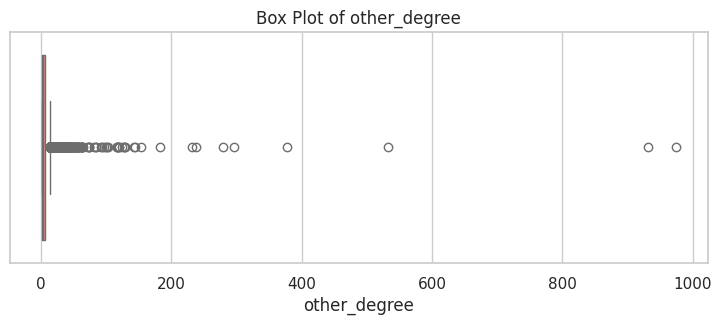

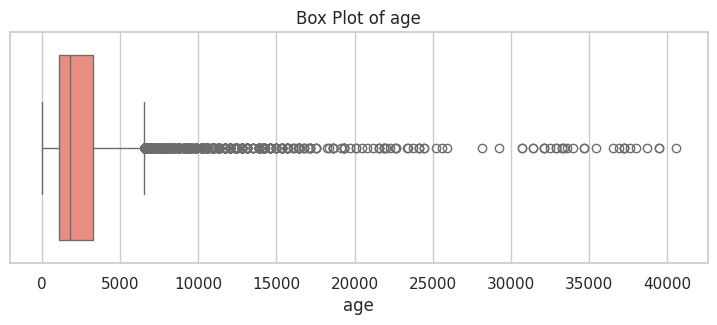

In [107]:
# 3. Distribution of Numerical Variables
numerical_cols = ["average_funded", "total_rounds", "average_participants",
                  "products_number", "offices", "acquired_companies",
                  "mba_degree", "phd_degree", "ms_degree", "other_degree", "age"]

for col in numerical_cols:
    plt.figure(figsize=(9, 3))
    sns.boxplot(x=df_crunchbase[col], color="salmon")
    plt.title(f"Box Plot of {col}")
    plt.xlabel(col)
    plt.show()
    print("\n")

### Bivariate Analysis

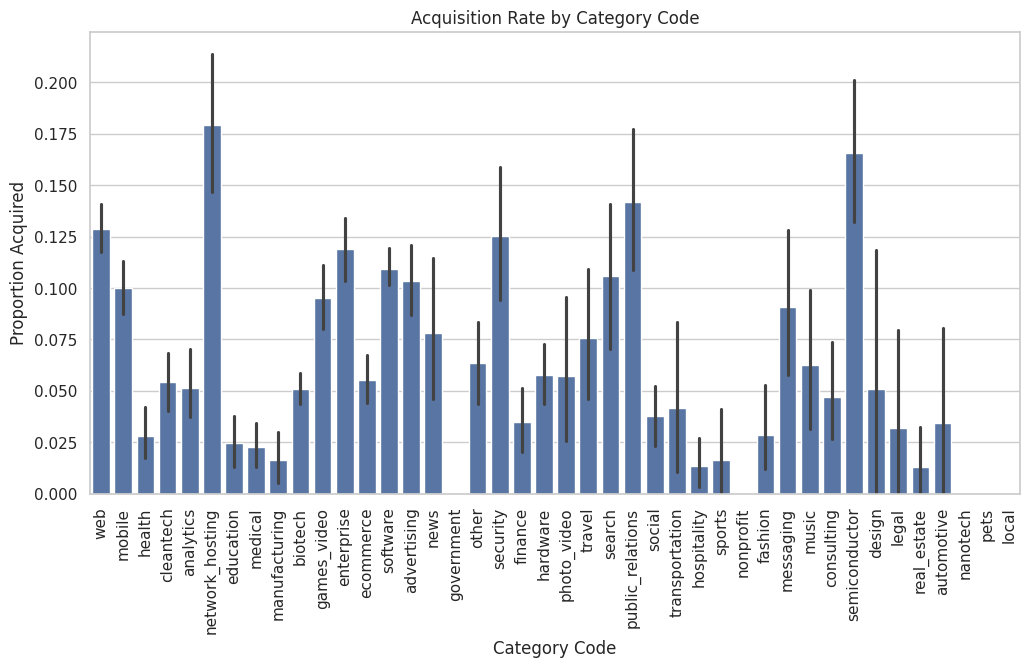

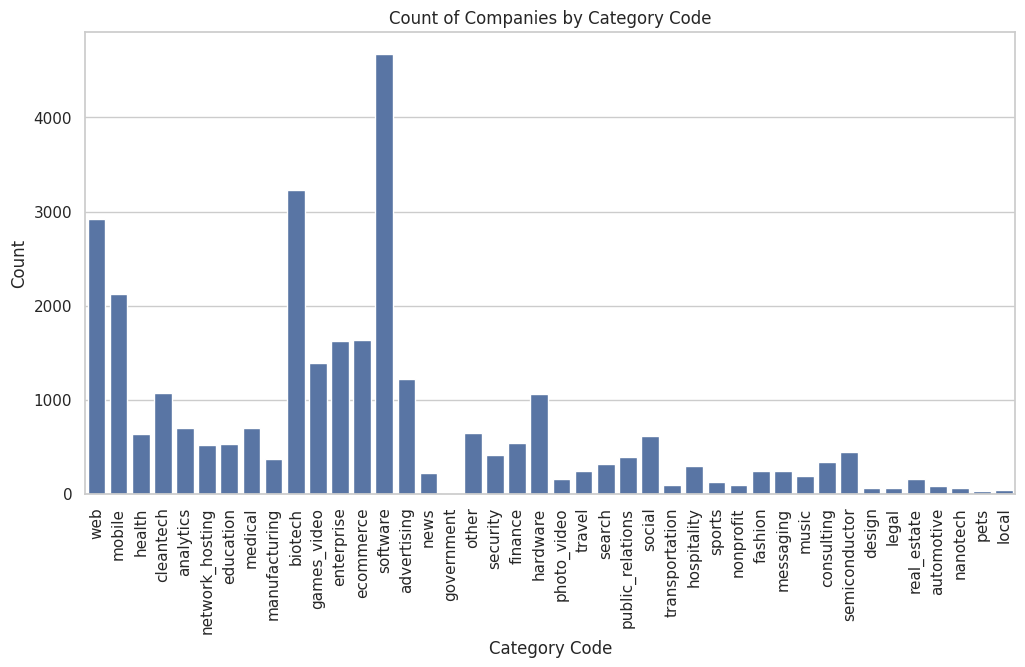

In [108]:
# Bar plot: Acquisition rate by category
plt.figure(figsize=(12, 6))
sns.barplot(x='category_code', y='is_acquired', data=df_crunchbase)
plt.xticks(rotation=90)
plt.title("Acquisition Rate by Category Code")
plt.xlabel("Category Code")
plt.ylabel("Proportion Acquired")
plt.show()

# Count plot: Number of companies per category
plt.figure(figsize=(12, 6))
sns.countplot(x='category_code', data=df_crunchbase)
plt.xticks(rotation=90)
plt.title("Count of Companies by Category Code")
plt.xlabel("Category Code")
plt.ylabel("Count")
plt.show()


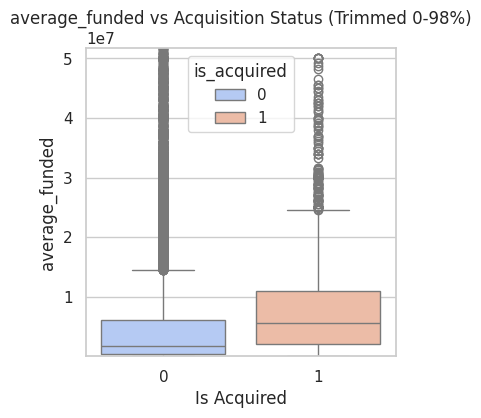

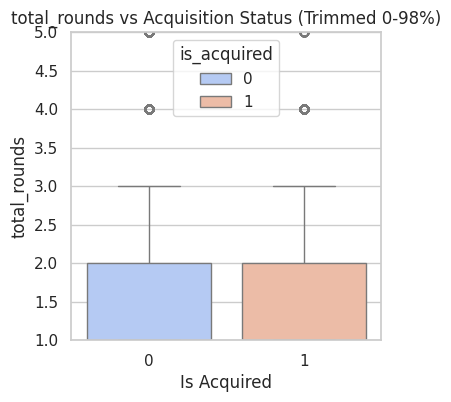

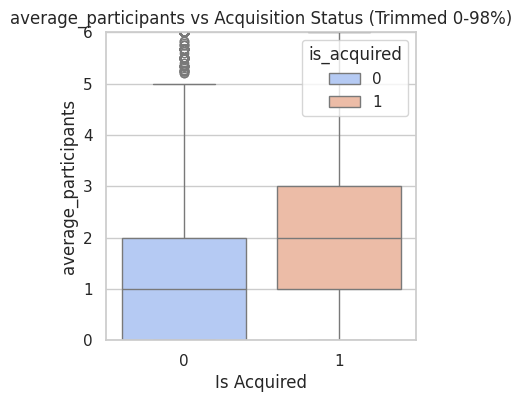

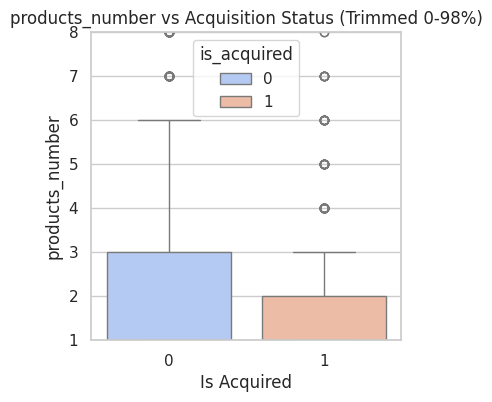

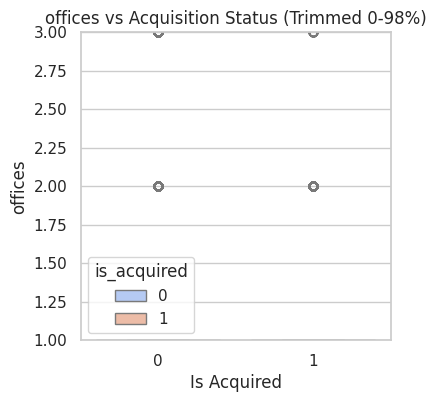

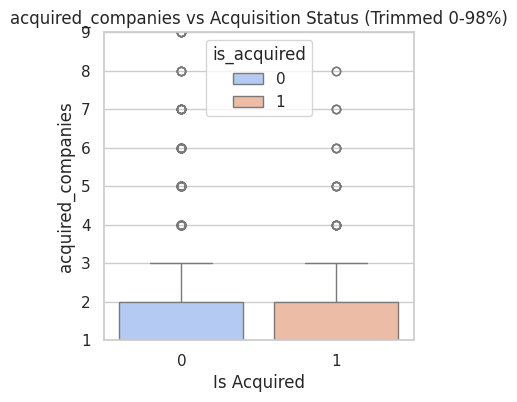

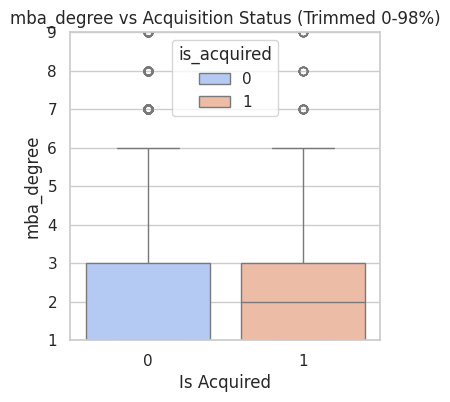

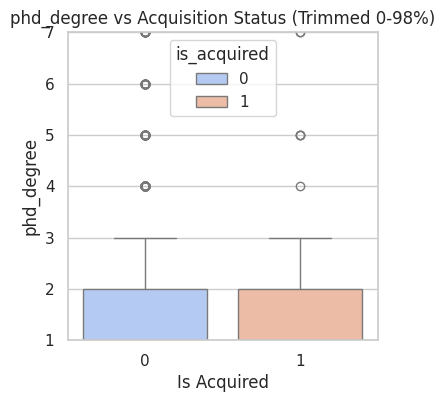

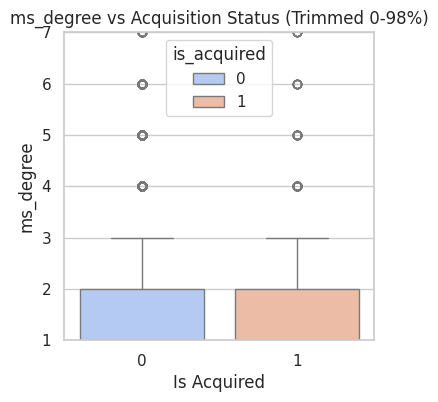

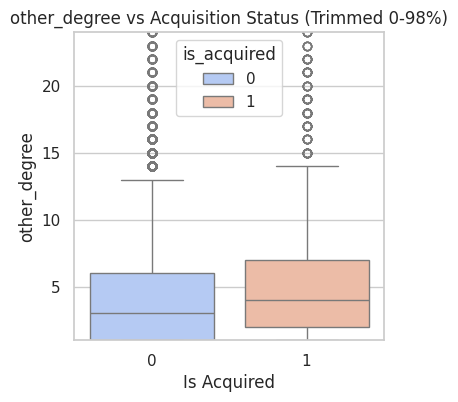

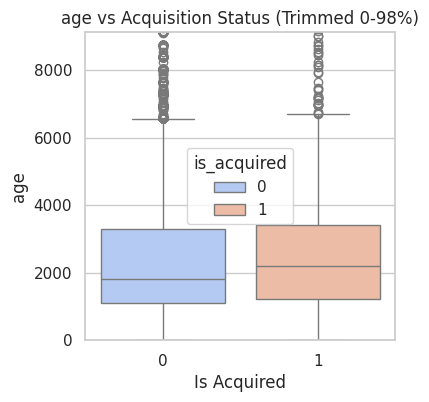

In [109]:
for col in numerical_cols:
    plt.figure(figsize=(4, 4))

    # Removing extreme outliers
    lower_bound = df_crunchbase[col].min()
    upper_bound = df_crunchbase[col].quantile(0.98)

    # Create the box plot with y-axis limited to 0-98% range
    ax = sns.boxplot(x="is_acquired", y=df_crunchbase[col], data=df_crunchbase, hue = "is_acquired", palette="coolwarm")
    plt.ylim(lower_bound, upper_bound)  # Set y-axis limits
    plt.title(f"{col} vs Acquisition Status (Trimmed 0-98%)")
    plt.xlabel("Is Acquired")
    plt.ylabel(col)
    plt.show()
    legend = ax.legend(title="Acquisition Status", loc="upper left")
    print("\n")


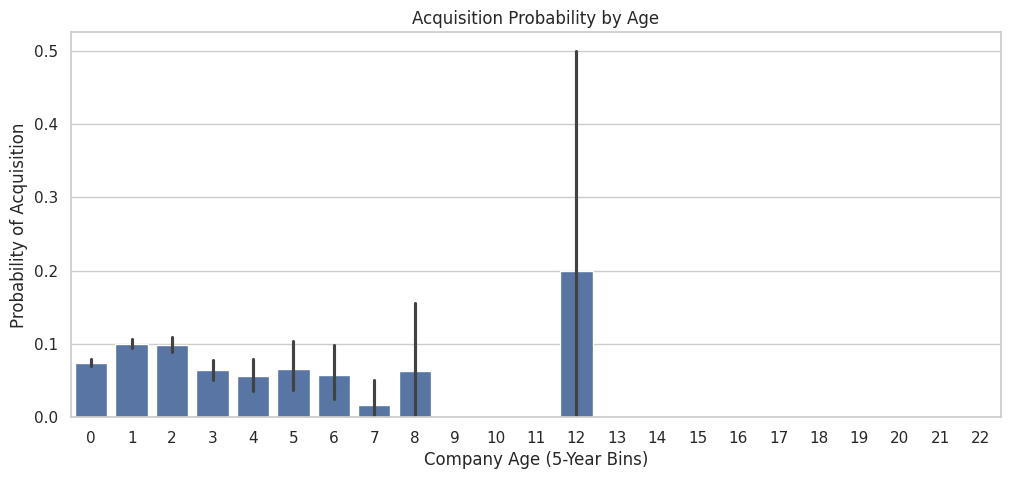

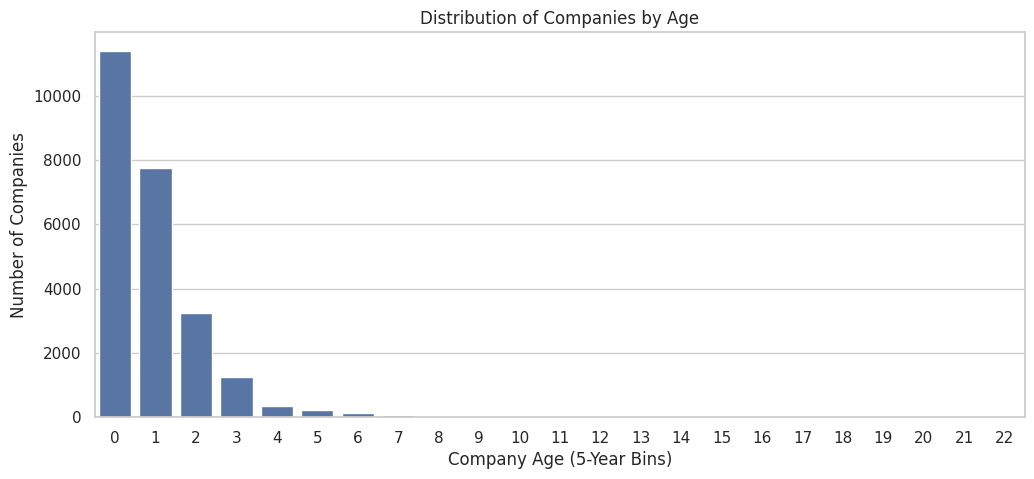

In [110]:
# Convert age to 5-year bins
age_acquisition = df_crunchbase[['age', 'is_acquired']].dropna().copy()
age_acquisition['age'] = (age_acquisition['age'] // (365 * 5)).astype(int)

# Bar plot: Acquisition probability by age
plt.figure(figsize=(12, 5))
sns.barplot(x='age', y='is_acquired', data=age_acquisition)
plt.title('Acquisition Probability by Age')
plt.xlabel('Company Age (5-Year Bins)')
plt.ylabel('Probability of Acquisition')
plt.show()

# Count plot: Number of companies in each age group
print("\n")
plt.figure(figsize=(12, 5))
sns.countplot(x='age', data=age_acquisition[age_acquisition['age'].notnull()])
plt.title('Distribution of Companies by Age')
plt.xlabel('Company Age (5-Year Bins)')
plt.ylabel('Number of Companies')
plt.show()

### Multivariate Analysis

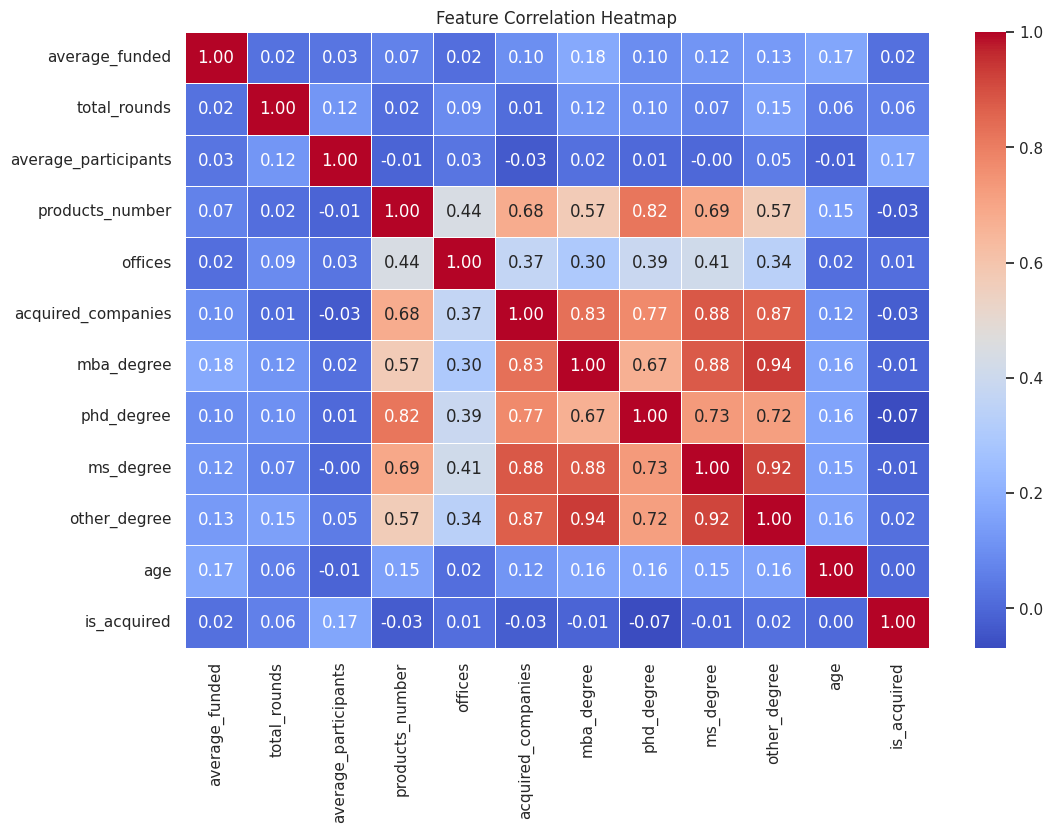

In [111]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df_crunchbase[numerical_cols + ["is_acquired"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

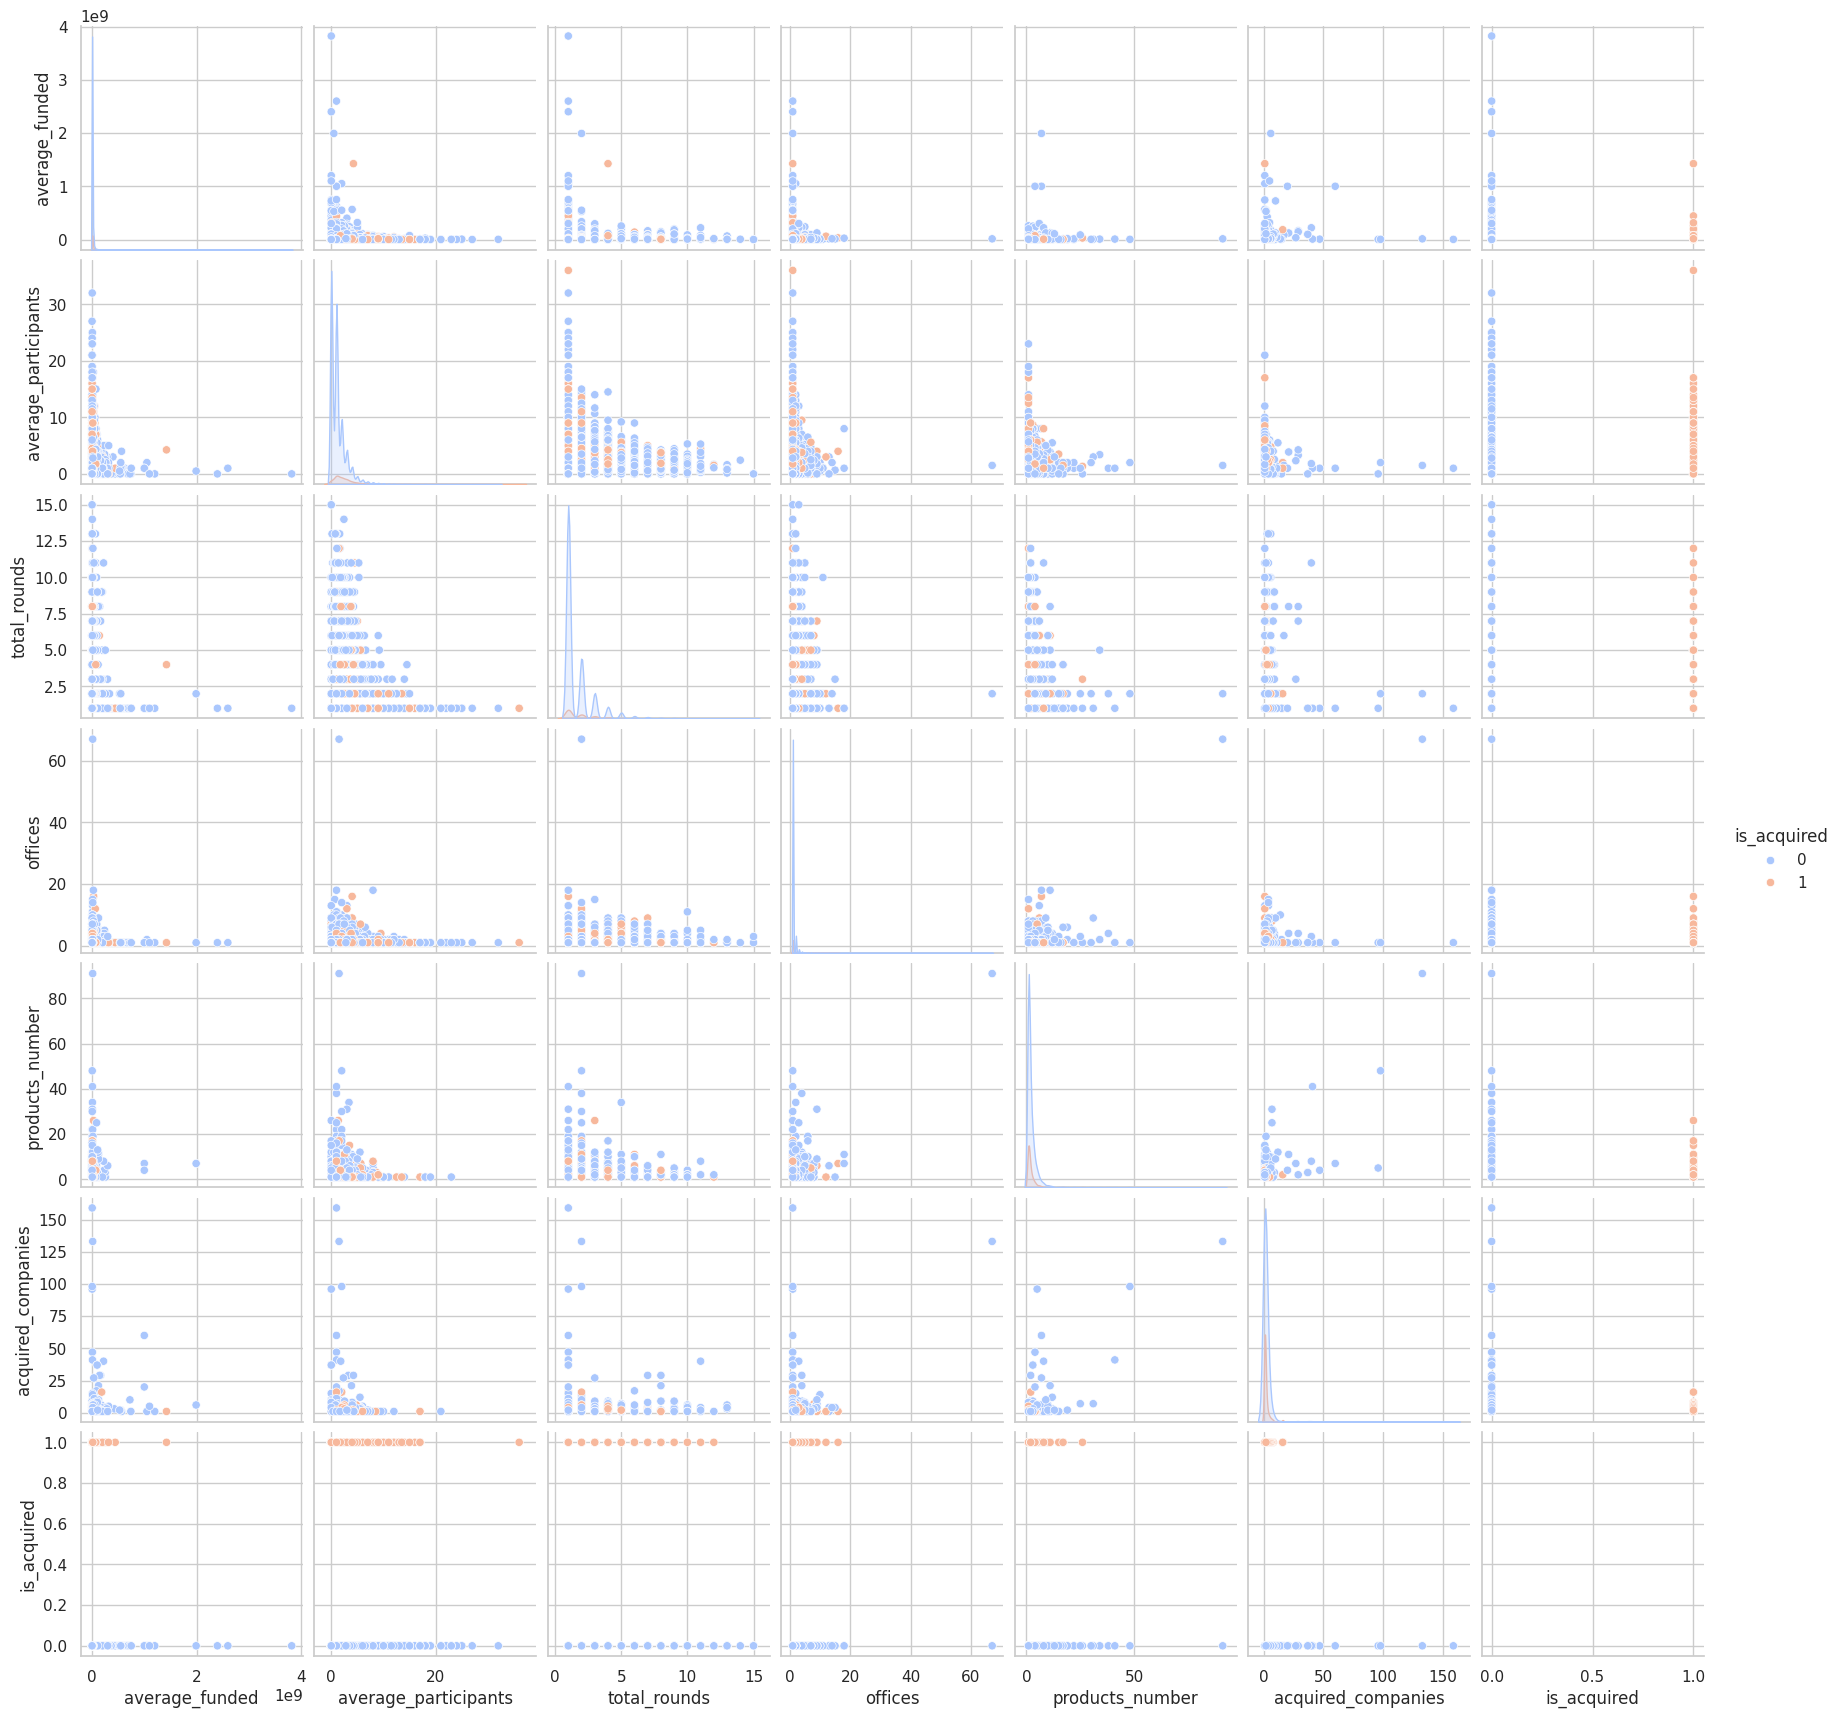

In [112]:
# Pair Plot
columns = ['average_funded', 'average_participants', 'total_rounds', 'offices',
                    'products_number', 'acquired_companies','is_acquired']
sns.pairplot(df_crunchbase, hue="is_acquired", vars=columns, palette="coolwarm")
plt.show()

## Data Preprocessing


In [113]:
df_processed = df_crunchbase.copy()

# Dropping columns with more than 50% missing values
missing_threshold = 0.50
missing_percent = df_processed.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index.tolist()

df_processed.drop(columns=cols_to_drop, inplace=True)
df_processed.drop(columns=["company_id"], inplace=True) # As company id isn't an independent variable

# Filling missing categorical values with "unknown"
categorical_cols = df_processed.select_dtypes(include=["object"]).columns.tolist()
df_processed[categorical_cols] = df_processed[categorical_cols].fillna("unknown")

# Impute missing numerical values with median (robust against outliers)
numerical_cols = df_processed.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_imputer = SimpleImputer(strategy="median")
df_processed[numerical_cols] = num_imputer.fit_transform(df_processed[numerical_cols])

# Apply one-hot encoding to categorical variables
df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

In [114]:
print(f"Final dataset shape: {df_processed.shape}")
print(f"Remaining missing values:\n{df_processed.isnull().sum().sum()}")

Final dataset shape: (31984, 53)
Remaining missing values:
0


In [115]:
X = df_processed.drop(columns=["is_acquired"])  # Features
y = df_processed["is_acquired"] # Target

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to oversample minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [116]:
# Scaling

numerical_cols.remove("is_acquired")
scaler = StandardScaler()
X_train_resampled[numerical_cols] = scaler.fit_transform(X_train_resampled[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [117]:
print(f"Final dataset shape after preprocessing: {df_processed.shape}")
print(f"Training set shape after SMOTE: {X_train_resampled.shape}")
print(f"Test set shape: {X_test.shape}")

Final dataset shape after preprocessing: (31984, 53)
Training set shape after SMOTE: (46962, 52)
Test set shape: (6397, 52)


## Model Building and Evaluation

In [118]:
# Function definition to check the performance of a model on train data
def calculate_performance_traindata(model_name, y_train, y_train_pred, train_pred_prob):
    '''
    model_name: Name of the model for identification
    y_train: True labels for the training set
    y_train_pred: Predicted labels for the training set
    train_pred_prob: Predicted probabilities for the training set
    '''

    print(f"{model_name} (Train Data):\n")

    # Calculate and print precision
    precision = metrics.precision_score(y_train, y_train_pred)
    print(f"Precision: {precision:.4f}")

    # Calculate and print recall
    recall = metrics.recall_score(y_train, y_train_pred)
    print(f"Recall: {recall:.4f}")

    # Calculate and print F1 score
    f1_score = metrics.f1_score(y_train, y_train_pred)
    print(f"F1 Score: {f1_score:.4f}")

    # Calculate and print ROC AUC
    roc_auc = metrics.roc_auc_score(y_train, train_pred_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate and print accuracy
    accuracy = metrics.accuracy_score(y_train, y_train_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

    # Return a DataFrame with all the scores
    return pd.DataFrame({
        "Model": [model_name+"-Train"],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1_score],
        "ROC AUC": [roc_auc],
        "Accuracy": [accuracy]
    })

In [119]:
# Function definition to check the performance of a model on test data

def calculate_performance_testdata(model_name, y_test, y_pred, pred_prob):
    '''
    model_name: Name of the model for identification
    y_test: True labels for the test set
    y_pred: Predicted labels for the test set
    pred_prob: Predicted probabilities for the test set
    '''

    print(f"{model_name} (Test Data):\n")

    # Calculate and print precision
    precision = metrics.precision_score(y_test, y_pred)
    print(f"Precision: {precision:.4f}")

    # Calculate and print recall
    recall = metrics.recall_score(y_test, y_pred)
    print(f"Recall: {recall:.4f}")

    # Calculate and print F1 score
    f1_score = metrics.f1_score(y_test, y_pred)
    print(f"F1 Score: {f1_score:.4f}")

    # Calculate and print ROC AUC
    roc_auc = metrics.roc_auc_score(y_test, pred_prob)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Calculate and print accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}\n")

    # Return a DataFrame with all the scores
    return pd.DataFrame({
        "Model": [model_name+"-Test"],
        "Precision": [precision],
        "Recall": [recall],
        "F1 Score": [f1_score],
        "ROC AUC": [roc_auc],
        "Accuracy": [accuracy]
    })


### Logistic Regression

In [120]:
# Building logistic regression model
log = LogisticRegression()
log_model = log.fit(X_train_resampled, y_train_resampled)

# Making predictions on the training data
y_train_pred = log_model.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob = log_model.predict_proba(X_train_resampled)

# Evaluating the model on the training data
train_performance_df = calculate_performance_traindata("Logistic Regression", y_train_resampled, y_train_pred, train_pred_prob[:, 1])

# Display the performance metrics for the training data
display(train_performance_df)

Logistic Regression (Train Data):

Precision: 0.9601
Recall: 0.8199
F1 Score: 0.8845
ROC AUC: 0.9534
Accuracy: 0.8929



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Logistic Regression-Train,0.96015,0.819854,0.884473,0.953354,0.892913


In [121]:
# Making predictions on the test data
y_test_pred = log_model.predict(X_test)

# Checking predict probability on PCA data for the test data
test_pred_prob = log_model.predict_proba(X_test)

# Evaluating the model on the test data
test_performance_df = calculate_performance_testdata("Logistic Regression", y_test, y_test_pred, test_pred_prob[:, 1])

# Displaying the performance metrics for the test data
display(test_performance_df)

Logistic Regression (Test Data):

Precision: 0.2392
Recall: 0.1160
F1 Score: 0.1562
ROC AUC: 0.7026
Accuracy: 0.8970



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Logistic Regression-Test,0.239216,0.11597,0.15621,0.702631,0.896983


#### Optimal Probability Threshold

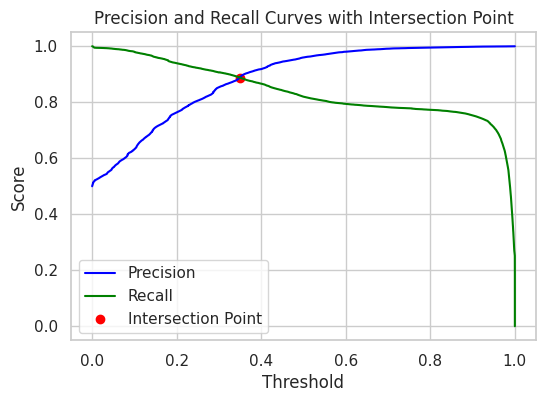

Intersection Threshold: 0.3495


In [122]:
# Predict probabilities on the training set
y_prob = log_model.predict_proba(X_train_resampled)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_train_resampled, y_prob)

# Calculate the area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Find the threshold where precision and recall intersect
intersection_threshold = thresholds[np.argmax(precision >= recall)]

# Plot precision and recall curves
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.scatter(intersection_threshold, precision[np.argmax(precision >= recall)], color='red', marker='o', label='Intersection Point')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves with Intersection Point')
plt.legend()
plt.show()

print(f"Intersection Threshold: {intersection_threshold:.4f}")

In [123]:
# Update training predictions using the optimal threshold
y_train_prob = log_model.predict_proba(X_train_resampled)[:, 1]
y_train_pred_final = (y_train_prob >= intersection_threshold).astype(int)

# Making predictions on the test data (using probabilities)
y_test_prob = log_model.predict_proba(X_test)[:, 1]
y_test_pred_final = (y_test_prob >= intersection_threshold).astype(int)


# Evaluating the model on the training data
train_performance_df_final = calculate_performance_traindata("Logistic Regression (Final)",
                                                              y_train_resampled,
                                                              y_train_pred_final,
                                                              y_train_prob)

# Display the performance metrics for the training data
print("\nFinal Training Performance Metrics:")
display(train_performance_df_final)

# Evaluating the model on the test data
test_performance_df_final = calculate_performance_testdata("Logistic Regression (Final)",
                                                            y_test,
                                                            y_test_pred_final,
                                                            y_test_prob)

# Display the performance metrics for the test data
print("\nFinal Test Performance Metrics:")
display(test_performance_df_final)

Logistic Regression (Final) (Train Data):

Precision: 0.8881
Recall: 0.8881
F1 Score: 0.8881
ROC AUC: 0.9534
Accuracy: 0.8881


Final Training Performance Metrics:


,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Logistic Regression (Final)-Train,0.888122,0.888122,0.888122,0.953354,0.888122


Logistic Regression (Final) (Test Data):

Precision: 0.2039
Recall: 0.3175
F1 Score: 0.2483
ROC AUC: 0.7026
Accuracy: 0.8420


Final Test Performance Metrics:


,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Logistic Regression (Final)-Test,0.203907,0.31749,0.248327,0.702631,0.841957


### Random Forest

In [126]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42, max_depth=3)
rf.fit(X_train_resampled, y_train_resampled)

# Making predictions on the training data
y_train_pred_rf = rf.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_rf = rf.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_rf = calculate_performance_traindata(
    "Random Forest", y_train_resampled, y_train_pred_rf, train_pred_prob_rf
)

# Display the performance metrics for the training data
display(train_performance_rf)

Random Forest (Train Data):

Precision: 0.7793
Recall: 0.8151
F1 Score: 0.7968
ROC AUC: 0.8759
Accuracy: 0.7922



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Random Forest-Train,0.779316,0.815127,0.796819,0.875925,0.792151


In [127]:
# Making predictions on the test data
y_test_pred_rf = rf.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_rf = calculate_performance_testdata(
    "Random Forest", y_test, y_test_pred_rf, test_pred_prob_rf
)

# Display the performance metrics for the test data
display(test_performance_rf)

Random Forest (Test Data):

Precision: 0.1818
Recall: 0.5894
F1 Score: 0.2779
ROC AUC: 0.7394
Accuracy: 0.7482



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Random Forest-Test,0.181818,0.589354,0.277902,0.739432,0.748163


#### Hyperparameter Tuning

In [128]:
# Define the parameter grid for randomized search
param_dist = {
    "n_estimators": [10, 25, 50, 75],
    "max_depth": [2, 3, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring="recall",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

# Fit the random search to the data
random_search_recall.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 75, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5}


In [129]:
# Train a tuned RandomForestClassifier with the best parameters
rf_tuned = RandomForestClassifier(random_state=42, **random_search_recall.best_params_)
rf_tuned.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=75, random_state=42)

In [130]:
# Making predictions on the training data
y_train_pred_rf_tuned = rf_tuned.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_rf_tuned = rf_tuned.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_rf_tuned = calculate_performance_traindata(
    "Random Forest (Tuned)", y_train_resampled, y_train_pred_rf_tuned, train_pred_prob_rf_tuned
)

# Display the performance metrics for the training data
display(train_performance_rf_tuned)

Random Forest (Tuned) (Train Data):

Precision: 0.8119
Recall: 0.8404
F1 Score: 0.8259
ROC AUC: 0.9065
Accuracy: 0.8229



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Random Forest (Tuned)-Train,0.811924,0.840382,0.825908,0.906497,0.822857


In [131]:
# Making predictions on the test data
y_test_pred_rf_tuned = rf_tuned.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_rf_tuned = calculate_performance_testdata(
    "Random Forest (Tuned)", y_test, y_test_pred_rf_tuned, test_pred_prob_rf_tuned
)

# Display the performance metrics for the test data
display(test_performance_rf_tuned)

Random Forest (Tuned) (Test Data):

Precision: 0.1981
Recall: 0.5513
F1 Score: 0.2915
ROC AUC: 0.7452
Accuracy: 0.7796



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Random Forest (Tuned)-Test,0.198087,0.551331,0.291457,0.745173,0.779584


### Gradient Boosting

In [132]:
# Initialize the GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=42, subsample=0.8)
gb.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42, subsample=0.8)

In [133]:
# Get model parameters
gb.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.8,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [134]:
# Making predictions on the training data
y_train_pred_gb = gb.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_gb = gb.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_gb = calculate_performance_traindata(
    "Gradient Boosting", y_train_resampled, y_train_pred_gb, train_pred_prob_gb
)

# Display the performance metrics for the training data
display(train_performance_gb)

Gradient Boosting (Train Data):

Precision: 0.9264
Recall: 0.8816
F1 Score: 0.9034
ROC AUC: 0.9655
Accuracy: 0.9058



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Gradient Boosting-Train,0.926385,0.881606,0.903441,0.965511,0.905775


In [135]:
# Making predictions on the test data
y_test_pred_gb = gb.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_gb = gb.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_gb = calculate_performance_testdata(
    "Gradient Boosting", y_test, y_test_pred_gb, test_pred_prob_gb
)

# Display the performance metrics for the test data
display(test_performance_gb)

Gradient Boosting (Test Data):

Precision: 0.2782
Recall: 0.3099
F1 Score: 0.2932
ROC AUC: 0.7571
Accuracy: 0.8771



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Gradient Boosting-Test,0.278157,0.309886,0.293165,0.757056,0.87713


In [136]:
# Define the parameter grid for randomized search
param_dist = {
    "n_estimators": [25, 50, 75, 100],
    "learning_rate": [0.01, 0.03, 0.04, 0.05],
    "max_depth": [2, 3, 5],
}

# Create the RandomizedSearchCV object with recall as the scoring metric
random_search_recall_gb = RandomizedSearchCV(
    gb,
    param_distributions=param_dist,
    n_iter=10,
    scoring="recall",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

# Fit the random search to the data
random_search_recall_gb.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_recall_gb.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


In [137]:
# Train a tuned GradientBoostingClassifier with the best parameters
gb_tuned = GradientBoostingClassifier(
    random_state=42, **random_search_recall_gb.best_params_, subsample=0.8
)
gb_tuned.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(learning_rate=0.05, random_state=42, subsample=0.8)

In [138]:
# Making predictions on the training data
y_train_pred_gb_tuned = gb_tuned.predict(X_train_resampled)

# Checking predict probability for the training data
train_pred_prob_gb_tuned = gb_tuned.predict_proba(X_train_resampled)[:, 1]

# Evaluating the model on the training data
train_performance_gb_tuned = calculate_performance_traindata(
    "Gradient Boosting (Tuned)", y_train_resampled, y_train_pred_gb_tuned, train_pred_prob_gb_tuned
)

# Display the performance metrics for the training data
display(train_performance_gb_tuned)

Gradient Boosting (Tuned) (Train Data):

Precision: 0.8726
Recall: 0.8742
F1 Score: 0.8734
ROC AUC: 0.9509
Accuracy: 0.8733



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Gradient Boosting (Tuned)-Train,0.872593,0.874154,0.873372,0.950936,0.873259


In [139]:
# Making predictions on the test data
y_test_pred_gb_tuned = gb_tuned.predict(X_test)

# Checking predict probability for the test data
test_pred_prob_gb_tuned = gb_tuned.predict_proba(X_test)[:, 1]

# Evaluating the model on the test data
test_performance_gb_tuned = calculate_performance_testdata(
    "Gradient Boosting (Tuned)", y_test, y_test_pred_gb_tuned, test_pred_prob_gb_tuned
)

# Display the performance metrics for the test data
display(test_performance_gb_tuned)

Gradient Boosting (Tuned) (Test Data):

Precision: 0.2136
Recall: 0.4049
F1 Score: 0.2797
ROC AUC: 0.7475
Accuracy: 0.8285



,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Gradient Boosting (Tuned)-Test,0.213641,0.404943,0.279711,0.74747,0.828513


### Model Comparison

In [141]:
# Creating DataFrames for performance metrics
train_performance_df_log = pd.DataFrame(train_performance_df_final, index=[0])
test_performance_df_log = pd.DataFrame(test_performance_df_final, index=[0])
train_performance_df_rf = pd.DataFrame(train_performance_rf_tuned, index=[0])
test_performance_df_rf = pd.DataFrame(test_performance_rf_tuned, index=[0])
train_performance_df_gb = pd.DataFrame(train_performance_gb_tuned, index=[0])
test_performance_df_gb = pd.DataFrame(test_performance_gb_tuned, index=[0])

# Concatenate the DataFrames with appropriate keys
combined_performance_df = pd.concat(
    [
        train_performance_df_log, test_performance_df_log,
        train_performance_df_rf, test_performance_df_rf,
        train_performance_df_gb, test_performance_df_gb
    ],
    keys=['Train_Log', 'Test_Log', 'Train_RF', 'Test_RF', 'Train_GB', 'Test_GB']
)

# Display the combined performance metrics
combined_performance_df_reset = combined_performance_df.reset_index(drop=True)
display(combined_performance_df_reset)


,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Logistic Regression (Final)-Train,0.888122,0.888122,0.888122,0.953354,0.888122
1,Logistic Regression (Final)-Test,0.203907,0.317490,0.248327,0.702631,0.841957
2,Random Forest (Tuned)-Train,0.811924,0.840382,0.825908,0.906497,0.822857
3,Random Forest (Tuned)-Test,0.198087,0.551331,0.291457,0.745173,0.779584
4,Gradient Boosting (Tuned)-Train,0.872593,0.874154,0.873372,0.950936,0.873259
5,Gradient Boosting (Tuned)-Test,0.213641,0.404943,0.279711,0.747470,0.828513
